## Installation & Render code

Run the code only once, then click the arrow by "Utility code" to hide them.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!conda install -c conda-forge hoomd gsd

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gsd
    - hoomd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    gsd-3.4.2                  |  py311h9ecbd09_0         263 KB  conda-forge
    hoomd-5.1.1                |cpu_py311he662963_0         6.4 MB  conda-forge
    libblas-3.9.0              |31_h59b9bed_openblas          16 KB  conda-forge
    libcblas-3.9.0             |31_he106b2a_openblas          16 KB  conda-forge
    libgfortran-14.2.0         |       h69a702a_2          52 KB  conda-forge
    libgfortran5-14.2.0        |

In [6]:
!conda install -c conda-forge fresnel freud

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - fresnel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    embree-4.3.3               |       h3173236_0         9.2 MB  conda-forge
    freetype-2.13.3            |       h48d6fc4_0         625 KB  conda-forge
    fresnel-0.13.7             |  py311hcb68df7_0         834 KB  conda-forge
    lcms2-2.17                 |       h717163a_0         242 KB  conda-forge
    lerc-4.0.0                 |       h27087fc_0         275 KB  conda-forge
    libdeflate-1.23            |       h4ddbbb0_0          71 KB  conda-forge
    libhwloc-2.11

In [24]:
import math
import warnings

import fresnel
import freud
import gsd.hoomd
import hoomd
import IPython
import matplotlib
import numpy
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.cm.get_cmap(name='viridis'))
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=20)._repr_png_())


warnings.filterwarnings('ignore', module='hoomd')

# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Create the simulation and initial state

Just like we did with HPMC.

In [26]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=2)

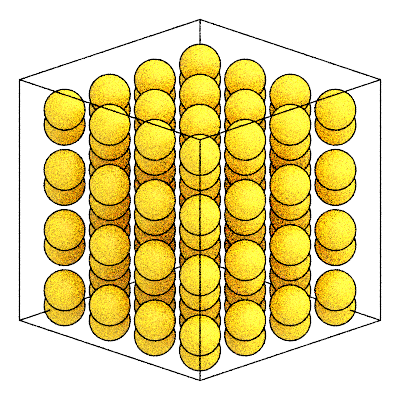

In [27]:
snapshot = hoomd.Snapshot()
box, positions = freud.data.UnitCell.bcc().generate_system(num_replicas=4,
                                                           scale=1.5)
snapshot.particles.N = len(positions)
snapshot.particles.position[:] = positions
snapshot.particles.types = ['A']
snapshot.configuration.box = [box.Lx, box.Ly, box.Lz, 0, 0, 0]
render(snapshot)

In [28]:
sim.create_state_from_snapshot(snapshot)

## Molecular dynamics classes

The MD integrator numerically integrates the equations of motion:

In [29]:
integrator = hoomd.md.Integrator(dt=0.005)

You need a neighbor list to compte pairwise interactions:

In [30]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

Compute Lennard-Jones interaction forces:
$$V_{\mathrm{LJ}}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

In [31]:
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)

Set `r_cut` to 2.5:

In [32]:
lj.r_cut[("A", "A")] = 2.5

Add the `lj` force to the integrator's `forces` list:

In [33]:
integrator.forces.append(lj)

The integration **method** sets the specific equations of motion that apply to a subset of particles:

In [35]:
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)

Add `nvt` to the integrator's `methods` list:

In [36]:
integrator.methods.append(nvt)

Remember to add the integrator to the simulation operations!

In [37]:
sim.operations += integrator

## Running a molecular dynamics simulation

HOOMD-blue defaults particle velocities to 0:

In [38]:
print(sim.state.get_snapshot().particles.velocity[0:5, :])

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Thermalize the velocities and integration method's degrees of freedom before running.

In [39]:
sim.state.thermalize_particle_momenta(filter=all_particles, kT=kT)
sim.run(0)
nvt.thermalize_thermostat_dof()
print(sim.state.get_snapshot().particles.velocity[0:5, :])

AttributeError: Object <class 'hoomd.md.methods.methods.ConstantVolume'> has no attribute thermalize_thermostat_dof

Run the simulation:

In [40]:
sim.run(100)

## Querying thermodynamic quantities

The `ThermodynamicQuantities` class computes properties of the simulation:

In [44]:
thermo = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
sim.operations += thermo
thermo.loggables

{'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar',
 'volume': 'scalar'}

Use `thermo` to get the `potential_energy` of the system:

In [46]:
thermo.potential_energy

-475.4542836890668

## Logging scalar quantities

Use a Logger to monitor how properties of the simulation vary during the run:

In [47]:
logger = hoomd.logging.Logger(categories=['scalar'])

Choose the specific quantities you want to log:

In [48]:
logger += sim
logger.add(thermo, quantities=['potential_energy'])

Use the `Table` writer to display the logged values:

In [49]:
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(100),
                          logger=logger,
                          max_header_len=5,
                          max_precision=2)
sim.operations += table

In [50]:
sim.run(1000)

 timestep     seed       tps      walltime  final_timestep initial_timestep potential_energy
   200         2      7.3969e+03  0.01338        1100            100          -4.48962e+02  
   300         2      6.2707e+03  0.03173        1100            100          -4.57790e+02  
   400         2      6.3514e+03  0.04708        1100            100          -4.59366e+02  
   500         2      6.2683e+03  0.06365        1100            100          -4.45556e+02  
   600         2      6.2257e+03  0.08015        1100            100          -4.76540e+02  
   700         2      6.2456e+03  0.09591        1100            100          -4.69851e+02  
   800         2      6.1955e+03  0.11282        1100            100          -4.64083e+02  
   900         2      6.0825e+03  0.13136        1100            100          -4.76877e+02  
   1000        2      6.0824e+03  0.14780        1100            100          -4.55485e+02  
   1100        2      6.1279e+03  0.16302        1100            100  

Remove the table writer:

In [51]:
sim.operations -= table

## Logging array quantities

HOOMD-blue can log array quantities, such as the per particle energies `lj.energies`:

In [52]:
lj.energies[0:5]

array([-2.40736765, -3.96170701, -2.23438348, -2.69375138, -3.64084255])

However, `Table` does not write array quantities. Create a new logger that accepts `'scalar'` and `'particle'` categories:

In [53]:
array_logger = hoomd.logging.Logger()

Then add the per-particle quantity `energies` from `lj` to it:

In [54]:
array_logger.add(lj, quantities=["energies", "forces"])

Include the logged quantities in a GSD trajectory:

In [63]:
gsd_writer = hoomd.write.GSD(
    filename="trajectory.gsd",
    trigger=hoomd.trigger.Periodic(100),
    logger=array_logger,
    mode="wb",
    filter=hoomd.filter.All(),
)
sim.operations += gsd_writer

Run the simulation to generate the file:

In [66]:
sim.run(10000)

In [68]:
!ls

condacolab_install.log	sample_data  trajectory.gsd


The values are available as numpy arrays:

In [58]:
with gsd.hoomd.open('trajectory.gsd', 'r') as trajectory:
    for frame in trajectory:
        energies = frame.log['particles/md/pair/LJ/energies']
        print(energies.mean(), energies.std())

Map the potential energy to particle color:

In [59]:
with gsd.hoomd.open('trajectory.gsd', 'r') as trajectory:
    image = render(trajectory[-1])
image

IndexError: 